### PARTICLE SWARM 

In [31]:
import numpy as np
np.set_printoptions(suppress=True)

In [32]:
%run fuzzy-pakar-jarak-z.ipynb

waktu belajar   : {'kecil': 0, 'sedang': 0, 'besar': 0.5528455284552846}
lama jawab soal : {'kecil': 0.2721417069243156, 'sedang': 0.3346456692913386, 'besar': 0}
nilai           : {'kecil': 0.0963855421686747, 'sedang': 0.50920245398773, 'besar': 0}
RULE 1: IF waktu_belajar kecil (0.0000) AND lama_jawab_soal kecil (0.2721) AND nilai kecil (0.0964) THEN kelulusan tidak lulus : ALPAPREDIKAT = 0.0000
RULE 2: IF waktu_belajar kecil (0.0000) AND lama_jawab_soal kecil (0.2721) AND nilai kecil (0.5092) THEN kelulusan tidak lulus : ALPAPREDIKAT = 0.0000
RULE 3: IF waktu_belajar kecil (0.0000) AND lama_jawab_soal kecil (0.2721) AND nilai kecil (0.0000) THEN kelulusan tidak lulus : ALPAPREDIKAT = 0.0000
RULE 4: IF waktu_belajar kecil (0.0000) AND lama_jawab_soal sedang (0.3346) AND nilai sedang (0.0964) THEN kelulusan tidak lulus : ALPAPREDIKAT = 0.0000
RULE 5: IF waktu_belajar kecil (0.0000) AND lama_jawab_soal sedang (0.3346) AND nilai sedang (0.5092) THEN kelulusan tidak lulus : ALPAPREDIKAT

In [33]:
class Particle:
    def __init__(self, bounds):
        self.bounds = bounds
        self.position = self._generate_position()
        self.velocity = self._generate_velocity()
        self.best_position = np.copy(self.position)
        self.best_score = -float('inf')

    def _generate_position(self):
        position = []
        for min_bound, max_bound, length in self.bounds:
            segment = np.random.uniform(min_bound, max_bound, size=length)
            position.extend(segment)
        return np.array(position)

    def _generate_velocity(self):   
        velocity = []
        for _, _, length in self.bounds:
            segment = np.random.uniform(-1, 1, size=length)
            velocity.extend(segment)
        return np.array(velocity)

    def update_velocity(self, global_best_position, w, c1, c2):
        r1 = np.random.rand(len(self.position))
        r2 = np.random.rand(len(self.position))
        self.velocity = w * self.velocity + c1 * r1 * (self.best_position - self.position) + c2 * r2 * (global_best_position - self.position)

    def update_position(self):
        self.position += self.velocity
        start_idx = 0
        for min_bound, max_bound, length in self.bounds:
            end_idx = start_idx + length
            self.position[start_idx:end_idx] = np.clip(
                self.position[start_idx:end_idx], min_bound, max_bound
            )
            start_idx = end_idx

In [34]:
def objective_function(particle_position, dataset):
    total_error = 0
    for i in range(len(dataset)):
        waktu_belajar = dataset.loc[i, 'rerata_durasi_akses_materi']
        lama_jawab_soal = dataset.loc[i, 'durasi_berlatih']
        nilai = dataset.loc[i, 'nilai']
        aktual_kelulusan = dataset.loc[i, 'kelulusan']
        # print(particle_position)
        x, y, z = func_fuzzifikasi(waktu_belajar, lama_jawab_soal, nilai, particle_position)
        # print(f"waktu belajar   : {x}")
        # print(f"lama jawab soal : {y}")
        # print(f"nilai           : {z}")
        hasil_inferensi, rule_text = inferensi_mamdani(x, y, z, rules)
        hasil_agregasi = agregasi(hasil_inferensi)
        hasil_defuzzifikasi = defuzzifikasi(hasil_agregasi)
        nilai_error = error_kelulusan(hasil_defuzzifikasi, kepercayaan_pakar)
        total_error += nilai_error
    akurasi = 100 - (total_error / len(dataset))
    # Menentukan indeks untuk elemen yang ingin diperiksa
    indices = [0, 4, 5, 9, 10, 14]
    # Mengecek apakah elemen-elemen pada indeks tersebut sama dengan 0
    if any(particle_position[i] == 0 for i in indices):
        akurasi = 0
    return akurasi

In [35]:
def ensure_constraints(particle_position):
    particle_position[1:4] = sorted(particle_position[1:4])
    particle_position[6:9] = sorted(particle_position[6:9])
    particle_position[11:14] = sorted(particle_position[11:14])

In [36]:
def particle_swarm_optimization(bounds, dataset, num_particles, max_iter, w=0.5, c1=2, c2=2):
    swarm = []
    temp = []
    for _ in range(num_particles):
        swarm.append(Particle(bounds))
    global_best_position = None
    global_best_score = -float('inf')

    for iteration in range(max_iter):
        for particle in swarm:
            # Evaluate fitness
            # print(particle.position)
            # print(len(particle.velocity))
            ensure_constraints(particle.position)
            particle_score = objective_function(particle.position, dataset)
            # print(particle_score)
            if particle_score > particle.best_score:
                particle.best_score = particle_score
                particle.best_position = np.copy(particle.position)

            if particle_score > global_best_score:
                global_best_score = particle_score
                global_best_position = np.copy(particle.position)

        # Update velocity and position
        for particle in swarm:
            particle.update_velocity(global_best_position, w, c1, c2)
            particle.update_position()
            # ensure_constraints(particle.position)
        temp.append(global_best_score)
        print(f"Iteration {iteration+1}/{max_iter}, Best Score: {global_best_score}")

    return global_best_position, global_best_score, temp

In [37]:
bounds = [
    (0, 700, 5),  # Elemen 1-5 dengan batas [0 - 700]
    (0, 7500, 5),  # Elemen 6-10 dengan batas [0, 7500]
    (0, 100, 5)  # Elemen 11 - 15 dengan batas [0, 100]
]

num_particles = 20
max_iter = 30
best_params, best_score, best_score_hist = particle_swarm_optimization(bounds, dataset, num_particles, max_iter)

print("\nOptimal Parameters:")
print(best_params)
print(f"Best Accuracy: {best_score:.4f}")

Iteration 1/30, Best Score: 68.19746906636564
Iteration 2/30, Best Score: 84.21152277660364
Iteration 3/30, Best Score: 84.21152277660364
Iteration 4/30, Best Score: 84.21152277660364
Iteration 5/30, Best Score: 84.21152277660364
Iteration 6/30, Best Score: 84.21152277660364
Iteration 7/30, Best Score: 87.55943901878948
Iteration 8/30, Best Score: 89.02848334892018
Iteration 9/30, Best Score: 89.43451311248775
Iteration 10/30, Best Score: 89.77913087362974
Iteration 11/30, Best Score: 89.77913087362974
Iteration 12/30, Best Score: 90.58105036441539
Iteration 13/30, Best Score: 91.45919945549983
Iteration 14/30, Best Score: 91.72354872539611
Iteration 15/30, Best Score: 91.72354872539611
Iteration 16/30, Best Score: 91.87898110348112
Iteration 17/30, Best Score: 91.87898110348112
Iteration 18/30, Best Score: 91.87898110348112
Iteration 19/30, Best Score: 91.87898110348112
Iteration 20/30, Best Score: 91.87898110348112
Iteration 21/30, Best Score: 91.90677042085177
Iteration 22/30, Best 

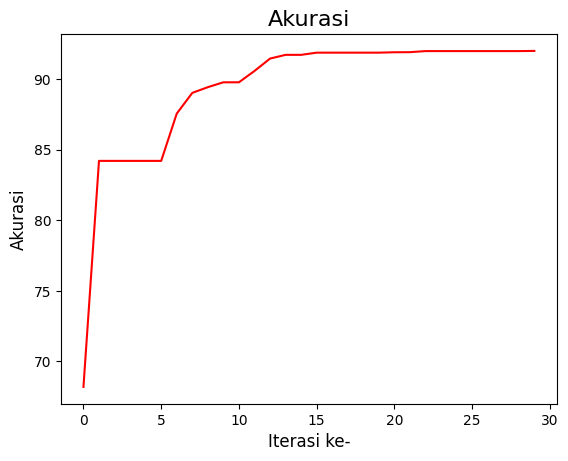

In [38]:
import matplotlib.pyplot as plt
plt.plot(best_score_hist, color="red")
plt.title("Akurasi", fontsize=16)
plt.xlabel("Iterasi ke-", fontsize=12)
plt.ylabel("Akurasi", fontsize=12)
plt.show()